## 사용 패키지

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor

from pycaret.regression import *

## 데이터 로드

In [240]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

# temp = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주체감온도.csv')
# rain = pd.read_csv(('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주강수.csv'))

In [241]:
# temp.columns = ['일자','기온','풍속','체감기온']

In [242]:
# train = pd.merge(train, temp)
# test = pd.merge(test, temp)

In [243]:
# rain.columns = ['일자', '강수량']
# rain.fillna(0, inplace=True)

In [244]:
# train = pd.merge(train,rain)
# test = pd.merge(test, rain)

In [245]:
# plt.figure(figsize=(12,6))
# sns.barplot(train['일'], train['강수량'])

In [246]:
# plt.figure(figsize=(12,6))
# sns.regplot(train2['강수량'] , train2['중식계'])

In [247]:
# expr = train['강수량'] > 80

In [248]:
# train2 = train[expr]

In [249]:
# train2

In [250]:
train.corr()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000


## 데이터

## 요일을 숫자로 매핑

In [251]:
#train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
#test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `요일 랭크지정 방식.`
## 석식에만 적용! 석식 수요일이 자기개발의 날 때문에 적어서.

In [252]:
weekdayrankfordinner = {
    '월' : 1,
    '화' : 2,
    '수' : 5,
    '목' : 3,
    '금' : 4
} 

train['요일(석식)'] = train['요일'].map(weekdayrankfordinner)
test['요일(석식)'] = test['요일'].map(weekdayrankfordinner)

## `월, 일을 숫자형으로 변환`

In [253]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week
train['요일'] = train['일자'].dt.weekday


test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week
test['요일'] = test['일자'].dt.weekday

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')



0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


In [254]:
train

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,요일(석식),년,월,일,주
0,2016-02-01,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,2016,2,1,5
1,2016-02-02,1,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2016,2,2,5
2,2016-02-03,2,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,5,2016,2,3,5
3,2016-02-04,3,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,3,2016,2,4,5
4,2016-02-05,4,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,4,2016,2,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,5,2021,1,20,3
1201,2021-01-21,3,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,3,2021,1,21,3
1202,2021-01-22,4,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,4,2021,1,22,3
1203,2021-01-25,0,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,1,2021,1,25,4


## `0712 비율변수 추가`

In [255]:
# train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
# train['출장비율'] = train['본사출장자수']/train['본사정원수']
# train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']


# test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
# test['출장비율'] = test['본사출장자수']/test['본사정원수']
# test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [256]:
# plt.figure(figsize=(12,6))
# sns.barplot(train['월'], train['중식계'])

In [257]:
# plt.figure(figsize=(12,6))
# sns.barplot(train['월'], train['석식계'])

In [258]:
# sampletrain = train.loc[:,('주','중식계','석식계')]
# sampletrain.groupby(['주']).mean().iloc[:,0].sort_values()

In [259]:
# sampletrain.groupby(['주']).mean().iloc[:,1].sort_values()

In [260]:
# sampletrain = train.loc[:,('월','중식계','석식계')]
# sampletrain.groupby(['월']).mean()

In [261]:
# expr = (train['년']>=2020) & (train['월'] >=1) & (train['월']<=4 )

In [262]:
# train[expr].mean()

## `월 랭크지정 방식` 낮은게 12 큰게 1 요일 랭크와 동일

In [263]:
month1 = {
    1:3,
    2:1,
    3:2,
    4:6,
    5:7,
    6:8,
    7:10,
    8:9,
    9:5,
    10:4,
    11:11,
    12:12
}

month2 = {
    1:11,
    2:2,
    3:1,
    4:4,
    5:8,
    6:6,
    7:9,
    8:7,
    9:5,
    10:3,
    11:10,
    12:12
}
train['월(중식)'] = train['월'].map(month1)
test['월(중식)'] = test['월'].map(month1)

train['월(석식)'] = train['월'].map(month2)
test['월(석식)'] = test['월'].map(month2)

train['월(중식)'] = train['월(중식)'].astype('int') # float형이라 int로 변경
test['월(중식)'] = test['월(중식)'].astype('int')
train['월(석식)'] = train['월(석식)'].astype('int')
test['월(석식)'] = test['월(석식)'].astype('int')

## `주 랭크지정 방식`


In [264]:
#중식
week1 = {
    52	:	52	,
    31	:	51	,
    33	:	50	,
    30	:	49	,
    32	:	48	,
    18	:	47	,
    46	:	46	,
    45	:	45	,
    47	:	44	,
    21	:	43	,
    44	:	42	,
    23	:	41	,
    51	:	40	,
    43	:	39	,
    28	:	38	,
    29	:	37	,
    42	:	36	,
    24	:	35	,
    17	:	34	,
    22	:	33	,
    26	:	32	,
    25	:	31	,
    27	:	30	,
    20	:	29	,
    15	:	28	,
    14	:	27	,
    16	:	26	,
    50	:	25	,
    19	:	24	,
    1	:	23	,
    3	:	22	,
    39	:	21	,
    36	:	20	,
    48	:	19	,
    2	:	18	,
    4	:	17	,
    37	:	16	,
    34	:	15	,
    13	:	14	,
    49	:	13	,
    35	:	12	,
    38	:	11	,
    12	:	10	,
    11	:	9	,
    6	:	8	,
    5	:	7	,
    9	:	6	,
    8	:	5	,
    10	:	4	,
    41	:	3	,
    7	:	2	,
    40	:	1	
}

#석식 위부터 작은수임

week2 = {
    52	:	52	,
    1	:	51	,
    31	:	50	,
    4	:	49	,
    48	:	48	,
    30	:	47	,
    26	:	46	,
    51	:	45	,
    43	:	44	,
    44	:	43	,
    46	:	42	,
    2	:	41	,
    17	:	40	,
    22	:	39	,
    33	:	38	,
    39	:	37	,
    29	:	36	,
    3	:	35	,
    32	:	34	,
    45	:	33	,
    18	:	32	,
    5	:	31	,
    47	:	30	,
    35	:	29	,
    23	:	28	,
    28	:	27	,
    37	:	26	,
    21	:	25	,
    19	:	24	,
    27	:	23	,
    24	:	22	,
    42	:	21	,
    9	:	20	,
    20	:	19	,
    38	:	18	,
    50	:	17	,
    25	:	16	,
    13	:	15	,
    16	:	14	,
    49	:	13	,
    12	:	12	,
    36	:	11	,
    15	:	10	,
    14	:	9	,
    34	:	8	,
    6	:	7	,
    11	:	6	,
    8	:	5	,
    7	:	4	,
    41	:	3	,
    10	:	2	,
    40	:	1	
}

train['주(중식)'] = train['주'].map(week1)
test['주(중식)'] = test['주'].map(week1)

train['주(석식)'] = train['주'].map(week2)
test['주(석식)'] = test['주'].map(week2)

train['주(중식)'] = train['주(중식)'].astype('int') # float형이라 int로 변경
test['주(중식)'] = test['주(중식)'].astype('int')
train['주(석식)'] = train['주(석식)'].astype('int')
test['주(석식)'] = test['주(석식)'].astype('int')

## `연도 랭크지정 방식` 효과 X

In [265]:
# year1 = {
#     2021 : 1,
#     2016 : 3,
#     2017 : 2,
#     2018 : 4,
#     2020 : 5,
#     2019 : 6
# }


# year2 = {
#     2016 : 1,
#     2017 : 3,
#     2018 : 2,
#     2019 : 4,
#     2020 : 5,
#     2021 : 6
# }





# train['년(중식)'] = train['년'].map(year1)
# test['년(중식)'] = test['년'].map(year1)

# train['년(석식)'] = train['년'].map(year2)
# test['년(석식)'] = test['년'].map(year2)

# train['년(중식)'] = train['년(중식)'].astype('int') # float형이라 int로 변경
# test['년(중식)'] = test['년(중식)'].astype('int')
# train['년(석식)'] = train['년(석식)'].astype('int')
# test['년(석식)'] = test['년(석식)'].astype('int')

## `일 랭크지정방식 ` 효과 X 사용안함

## `식사가능자수`

In [266]:
train['식사가능자수'] = (train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수'])
test['식사가능자수'] = (test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수'])

In [267]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

In [268]:
train['식사가능자수']

0       2551.0
1       2551.0
2       2545.0
3       2497.0
4       2323.0
         ...  
1200    2517.0
1201    2540.0
1202    2425.0
1203    2549.0
1204    2552.0
Name: 식사가능자수, Length: 1205, dtype: float64

# `0708 공휴일 전후 추가 `

## `0713 공휴일 변경`

In [269]:
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [270]:
#휴일
train['휴일전날'] = 0
test['휴일전날'] = 0

train['휴일다음날'] = 0
test['휴일다음날'] = 0

#연휴 (주말포함 3일이상 휴일)
train['연휴전날'] = 0
test['연휴전날'] = 0

train['연휴다음날'] = 0
test['연휴다음날'] = 0

In [271]:
train['휴일다음날'][train['요일'] == 0] = 1 # 월요일
test['휴일다음날'][test['요일'] == 0] = 1

train['휴일전날'][train['요일'] == 4] = 1 # 금요일
test['휴일전날'][test['요일'] == 4] = 1

# 2016년
train['휴일전날'][17] = 1
train['휴일전날'][47] = 1
train['휴일전날'][62] = 1
train['휴일전날'][17] = 1
train['휴일전날'][152] = 1

test['휴일다음날'][5] = 1
test['휴일다음날'][18] = 1
test['휴일다음날'][48] = 1
test['휴일다음날'][83] = 1
test['휴일다음날'][132] = 1
test['휴일다음날'][163] = 1

#2017년
train['휴일전날'][245] = 1
train['휴일전날'][268] = 1
train['휴일전날'][309] = 1
train['휴일전날'][310] = 1
train['휴일전날'][330] = 1
train['휴일전날'][379] = 1

test['휴일다음날'][227] = 1
test['휴일다음날'][246] = 1
test['휴일다음날'][267] = 1
test['휴일다음날'][309] = 1
test['휴일다음날'][310] = 1
test['휴일다음날'][331] = 1
test['휴일다음날'][380] = 1
test['휴일다음날'][413] = 1
test['휴일다음날'][467] = 1


#2018년
train['휴일전날'][502] = 1
train['휴일전날'][510] = 1
train['휴일전날'][555] = 1
train['휴일전날'][565] = 1
train['휴일전날'][575] = 1
train['휴일전날'][579] = 1
train['휴일전날'][623] = 1
train['휴일전날'][651] = 1
train['휴일전날'][705] = 1
train['휴일전날'][709] = 1

test['휴일다음날'][471] = 1
test['휴일다음날'][511] = 1
test['휴일다음날'][556] = 1
test['휴일다음날'][566] = 1
test['휴일다음날'][576] = 1
test['휴일다음날'][580] = 1
test['휴일다음날'][624] = 1
test['휴일다음날'][652] = 1
test['휴일다음날'][706] = 1


#2019년
train['휴일전날'][728] = 1
train['휴일전날'][814] = 1
train['휴일전날'][863] = 1
train['휴일전날'][882] = 1
train['휴일전날'][894] = 1
train['휴일전날'][897] = 1
train['휴일전날'][951] = 1
train['휴일전날'][893] = 1
train['휴일전날'][955] = 1

test['휴일다음날'][710] = 1
test['휴일다음날'][733] = 1
test['휴일다음날'][793] = 1
test['휴일다음날'][815] = 1
test['휴일다음날'][864] = 1
test['휴일다음날'][894] = 1
test['휴일다음날'][898] = 1
test['휴일다음날'][952] = 1
test['휴일다음날'][895] = 1


#2020년
train['휴일전날'][971] = 1
train['휴일전날'][1027] = 1
train['휴일전날'][1037] = 1
train['휴일전날'][1038] = 1
train['휴일전날'][1133] = 1
train['휴일전날'][1187] = 1

test['휴일다음날'][956] = 1
test['휴일다음날'][972] = 1
test['휴일다음날'][996] = 1
test['휴일다음날'][1028] = 1
test['휴일다음날'][1039] = 1

#2021년
test['휴일전날'][10] = 1
test['휴일다음날'][21] = 1



# # 원핫인코딩
# train = pd.get_dummies(train, columns=['공휴일전후'])
# test = pd.get_dummies(test, columns=['공휴일전후'])

# test['공휴일전후_0'][20] =1
# test['공휴일전후_1'][20] = 0

In [272]:
train['휴일다음날'][train['요일'] == 0] = 1
test['휴일다음날'][test['요일'] == 0] = 1

train['휴일전날'][train['요일'] == 4] = 1
test['휴일전날'][test['요일'] == 4] = 1


# 요일 원핫인코딩 
train = pd.get_dummies(train, columns=['요일'])
test = pd.get_dummies(test, columns=['요일'])
# 요일_0 : 월 / 요일_1 : 화 / 요일_2 : 수 / 요일_3 : 목 / 요일_4 : 금

## `0714 연휴 전 후 추가(주말포함 3일이상 휴일)`

In [273]:
#2016
train['연휴전날'][4] = 1
train['연휴전날'][82] = 1
train['연휴전날'][131] = 1
train['연휴전날'][152] = 1
train['연휴전날'][162] = 1

train['연휴다음날'][5] = 1
train['연휴다음날'][83] = 1
train['연휴다음날'][132] = 1
train['연휴다음날'][153] = 1
train['연휴다음날'][163] = 1


#2017
train['연휴전날'][245] = 1
train['연휴전날'][309] = 1
train['연휴전날'][310] = 1
train['연휴전날'][412] = 1
train['연휴전날'][466] = 1
train['연휴전날'][470] = 1

train['연휴다음날'][246] = 1
train['연휴다음날'][309] = 1
train['연휴다음날'][310] = 1
train['연휴다음날'][413] = 1
train['연휴다음날'][467] = 1


#2018
train['연휴전날'][502] = 1
train['연휴전날'][555] = 1
train['연휴전날'][650] = 1

train['연휴다음날'][471] = 1
train['연휴다음날'][503] = 1
train['연휴다음날'][556] = 1
train['연휴다음날'][651] = 1

#2019
train['연휴전날'][732] = 1
train['연휴전날'][748] = 1
train['연휴전날'][792] = 1
train['연휴전날'][882] = 1

train['연휴다음날'][733] = 1
train['연휴다음날'][749] = 1
train['연휴다음날'][793] = 1
train['연휴다음날'][883] = 1

#2020
train['연휴전날'][971] = 1
train['연휴전날'][1129] = 1
train['연휴전날'][1187] = 1

train['연휴다음날'][972] = 1
train['연휴다음날'][1130] = 1

#2021
test['연휴전날'][10] = 1
test['연휴전날'][20] = 1


train['연휴다음날'][1188] = 1

test['연휴다음날'][11] = 1
test['연휴다음날'][21] = 1


## Feature

In [274]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [275]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #중식계
x2_train = train[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #석식계

y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]
x2_test = test[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수', '월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]

KeyError: "['공휴일전후_0', '공휴일전후_2', '공휴일전후_1', '요일'] not in index"

## `0714 휴일 전, 후 / 요일 원핫인코딩 Feature`

In [305]:
x1_train = train[['본사시간외근무명령서승인건수', '식사가능자수','월(중식)','일','휴일전날','휴일다음날','연휴전날','연휴다음날','본사출장자수','요일_0','요일_1','요일_2','요일_3','요일_4']] #중식계
x2_train = train[['본사시간외근무명령서승인건수', '식사가능자수','월(석식)','일','휴일전날','휴일다음날','연휴전날','연휴다음날','본사출장자수','요일_0','요일_1','요일_2','요일_3','요일_4']] #석식계

y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['본사시간외근무명령서승인건수', '식사가능자수', '월(중식)','일','휴일전날','휴일다음날','연휴전날','연휴다음날','본사출장자수','요일_0','요일_1','요일_2','요일_3','요일_4']]
x2_test = test[['본사시간외근무명령서승인건수', '식사가능자수', '월(석식)','일','휴일전날','휴일다음날','연휴전날','연휴다음날','본사출장자수','요일_0','요일_1','요일_2','요일_3','요일_4']]

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [306]:
# model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
# model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

## 학습

In [307]:
# model1.fit(x1_train, y1_train) #중식계
# model2.fit(x2_train, y2_train) #석식계

## 추론

In [308]:
# pred1 = model1.predict(x1_test)
# pred2 = model2.predict(x2_test)

## 결과 제출

In [292]:
# submission['중식계'] = pred1
# submission['석식계'] = pred2

In [293]:
# submission.to_csv('baseline.csv', index=False)

# `Kfold 적용 버전`

In [228]:
# from sklearn.model_selection import KFold
# k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [229]:
# model1.fit(x1_train, y1_train) #중식계
# model2.fit(x2_train, y2_train) #석식계

In [230]:
# model1 = cat
# models1 = [] # 교차검증을 위한 바구나 5개

# for train_idx, val_idx in k_fold.split(x1_train):
#     x1_t = x1_train.iloc[train_idx]
#     y1_t = y1_train.iloc[train_idx]
#     x1_val = x1_train.iloc[val_idx]
#     y1_val = y1_train.iloc[val_idx]
    
#      models1.append(model1.fit(x1_t, y1_t))#, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

# preds1 = []
# for model1 in models1:
#     preds1.append(model1.predict(x1_test))    


# model2 = cat
# models2 = [] # 교차검증을 위한 바구나 5개

# for train_idx, val_idx in k_fold.split(x2_train):
#     x2_t = x2_train.iloc[train_idx]
#     y2_t = y2_train.iloc[train_idx]
#     x2_val = x2_train.iloc[val_idx]
#     y2_val = y2_train.iloc[val_idx]
    
#     models2.append(model2.fit(x2_t, y2_t))#, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

# preds2 = []
# for model2 in models2:
#     preds2.append(model2.predict(x2_test))

In [231]:
# pred1 = np.mean(preds1, axis=0)
# pred2 = np.mean(preds2, axis=0)

In [232]:
# submission['중식계'] = pred1
# submission['석식계'] = pred2

In [233]:
# submission.to_csv('baseline0712.csv', index=False)

## `앙상블 모델 적용 버전`

In [296]:
# 메뉴
train_lunch = pd.concat([x1_train, train['중식계']], axis = 1) # concat cbind 역할
train_dinner = pd.concat([x2_train, train['석식계']], axis = 1)
test_lunch = pd.concat([x1_test], axis = 1)
test_dinner = pd.concat([x2_test], axis = 1)
print('done')

done


### 중식 모델링

In [297]:
reg = setup(data=pd.concat([x1_train,train['중식계']], axis=1), # concat cbind 역할
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)
print('done')

,Description,Value
0,session_id,3121
1,Target,중식계
2,Original Data,"(1205, 14)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 12)"


done


In [298]:
best_5_l = compare_models(sort='MAE', n_select=5)
print('done')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,75.1612,10279.6703,100.9315,0.7652,0.1248,0.0921,2.4420
rf,Random Forest Regressor,75.9469,10581.3148,102.1599,0.7591,0.1272,0.0934,0.2500
gbr,Gradient Boosting Regressor,77.4005,10923.8861,103.9778,0.7523,0.1293,0.0951,0.0660
et,Extra Trees Regressor,77.9851,10895.6693,103.8712,0.7506,0.1269,0.0948,0.2140
lightgbm,Light Gradient Boosting Machine,79.8987,11353.5962,106.0195,0.7408,0.1313,0.0977,0.0500
knn,K Neighbors Regressor,83.9508,12831.9781,112.5837,0.7086,0.1416,0.1049,0.0180
huber,Huber Regressor,85.0035,14154.4208,117.3467,0.6797,0.1486,0.1089,0.0410
lr,Linear Regression,87.9760,13517.2762,115.2665,0.6950,0.1452,0.1105,0.8590
lar,Least Angle Regression,87.9760,13517.2762,115.2665,0.6950,0.1452,0.1105,0.0120
ridge,Ridge Regression,87.9952,13495.2208,115.2154,0.6954,0.1453,0.1105,0.0100


done


In [299]:
blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)

pred_esb_l = predict_model(final_model_l, test_lunch)

pred_esb_l['Label']

submission_esb = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

print('done')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,78.9738,11104.5861,105.3783,0.7520,0.1302,0.0956
1,70.9912,9573.3370,97.8434,0.7765,0.1146,0.0823
2,79.8403,12741.5554,112.8785,0.6803,0.1381,0.0975
3,72.7206,9103.8351,95.4140,0.7968,0.1097,0.0838
4,80.8468,11238.9587,106.0140,0.7851,0.1454,0.1092
Mean,76.6745,10752.4545,103.5056,0.7581,0.1276,0.0937
SD,4.0162,1298.1116,6.2479,0.0416,0.0136,0.0098


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,74.2737,10105.0837,100.5240,0.7522,0.1246,0.0891


done


### 석식모델링

In [300]:
reg = setup(data=pd.concat([x2_train,train['석식계']], axis=1), # concat cbind 역할
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)
print('done')

,Description,Value
0,session_id,8888
1,Target,석식계
2,Original Data,"(1205, 14)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 12)"


done


In [301]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)
print('done')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,68.4106,9619.3285,97.0728,0.5132,1.0413,0.1388,1.9040
et,Extra Trees Regressor,69.0203,10779.8202,102.7708,0.4538,1.0498,0.1385,0.1980
rf,Random Forest Regressor,69.4255,10286.7026,100.6087,0.4760,1.0563,0.1407,0.2380
gbr,Gradient Boosting Regressor,70.5819,10261.1285,100.3334,0.4823,1.0555,0.1410,0.0810
huber,Huber Regressor,72.8437,11939.3896,107.9812,0.4009,1.0901,0.1461,0.0550
lightgbm,Light Gradient Boosting Machine,74.2216,11014.6539,104.1920,0.4379,1.0564,0.1513,0.0410
lar,Least Angle Regression,76.2008,11476.4217,106.2000,0.4181,1.0713,0.1558,0.0120
lr,Linear Regression,76.2008,11476.4217,106.2000,0.4181,1.0713,0.1558,0.0220
knn,K Neighbors Regressor,76.2459,12486.7268,110.3364,0.3758,1.0818,0.1572,0.0140
ridge,Ridge Regression,76.2629,11452.0771,106.1043,0.4194,1.0715,0.1564,0.0090


done


In [302]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)
print('done')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.1518,8269.0404,90.9343,0.5417,1.0110,0.1303
1,66.9222,10262.7966,101.3055,0.4300,1.1340,0.1338
2,74.5002,12194.4519,110.4285,0.4453,1.2077,0.1426
3,70.8146,10546.6265,102.6968,0.5445,1.1966,0.1361
4,64.9130,8056.8651,89.7600,0.5760,1.0850,0.1332
Mean,67.8604,9865.9561,99.0250,0.5075,1.1268,0.1352
SD,4.3582,1540.4958,7.7462,0.0585,0.0730,0.0042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,67.6648,10864.9329,104.2350,0.3872,1.0845,0.1353


done


In [303]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [304]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,1016.139056,366.416865
1,2021-01-28,994.557871,457.582746
2,2021-01-29,598.310459,274.468599
3,2021-02-01,1248.244899,600.080003
4,2021-02-02,1025.004559,580.442059
5,2021-02-03,1089.079406,467.823237
6,2021-02-04,1018.924076,564.314360
7,2021-02-05,707.231796,345.756399
8,2021-02-08,1237.319390,668.647660
9,2021-02-09,1036.275512,584.689365


In [216]:
submission_esb.to_csv('ensembleW.csv', index = False)

- 0708 23:11

randomforest default mae로 바꿈(대회 측정방식)->mae:73 mse:66 오히려 mse가 더 좋게나왔음..

- 0709 00:28

출장자수 변수추가했더니 1점 높게나옴. 추가할 것

- 0709 20:35
    
체감온도 추가 효과 오히려 감소

- 0709 21:38

월 매핑 -> 0.5점 상승! 체감온도는 그냥 뺐음..

---
- 0710 01:51

앙상블 모델 적용.
효과는 안좋았음. 테스트용으로만 써보자.


`중식` 중식개선필요.

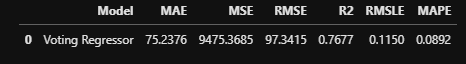

`석식`

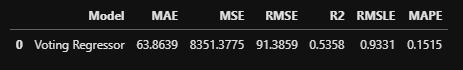

---
- 0711 13:59
    
월 매핑 제대로 안돼있었음.. 수정 후 제출! 63.792 `최고기록`

`중식`

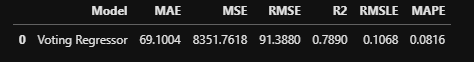

`석식`

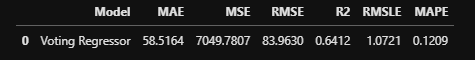


---
- 0711 14:46

연도 매핑 후 연도 추가. 중식은 성능 안좋길래 석식만 넣고 제출 그런데 결과는 68점; 연도 다시 제거!!

`중식`

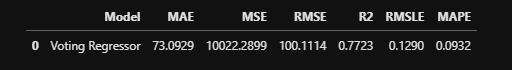

`석식`

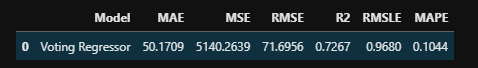

---
- 0711 17:03

일 매핑. 결과 안좋음.. 제거!

---
- 0711 17:26
    
휴가자수 식사가능자수에서 뺐지만 따로 추가해주었음. 파일명 : ensembleVacc.csv

`중식`

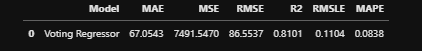

`석식` 

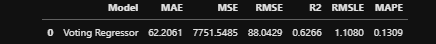

---
- 0711 17:51
    
식사가능자수 <- 식사가능자수/본사정원수로 잠시 변경, 휴가자수도 뺌

`중식`

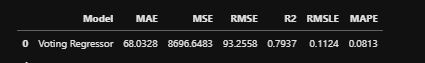

`석식`

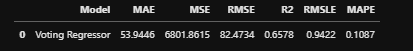

제출결과 안좋음.. 다시 복구

---
- 0712 00:23

휴가자수 임의로 더한걸 뺀다고 생각하고 출장자수를 없앴었음.... 그래서 계속 작게나옴;

이번엔 주, 년을 모두 추가하고 돌려봤다./ 해사꺼 비율시리즈 다 추가했더니 72점나옴.....

`중식`

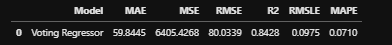

`석식`

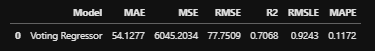

---
- 0712 01:15
    
최고기록에 주 랭크매핑 후 제출. 66.195점.. 낮게나옴



`중식`

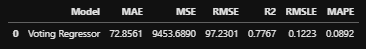

`석식`

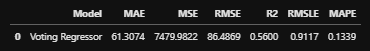

---
- 0714 
일 대신 주를 넣어서 비교.

`일을넣은 앙상블`

중식

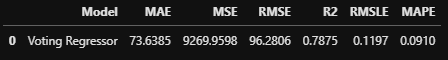

석식

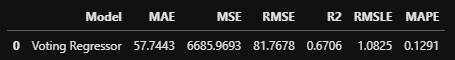

`주를넣은 앙상블`


중식

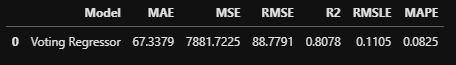

석식

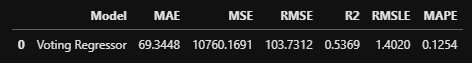

중식은 주를 넣고 석식은 일을 넣어보자 > 3점 더 안좋게나옴.. 그대로 일을 쓰자..

# `Catboost + Kfold`

In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

model1 = cat
model2 = cat

model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x1_test)

model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x2_test)

from sklearn.model_selection import KFold

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x1_test))    


model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x2_test))
    
pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

submission['중식계'] = pred1
submission['석식계'] = pred2

submission.to_csv('catKfold.csv', index=False)

# `Catboost 만 `

In [309]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

model1 = cat
model2 = cat

model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x1_test)

model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x2_test)

submission['중식계'] = pred1
submission['석식계'] = pred2


submission.to_csv('catholi_day.csv', index=False)


Learning rate set to 0.040347
0:	learn: 204.0005349	total: 3.44ms	remaining: 3.44s
1:	learn: 198.9069511	total: 6.21ms	remaining: 3.1s
2:	learn: 194.1108540	total: 8.64ms	remaining: 2.87s
3:	learn: 189.6022291	total: 11ms	remaining: 2.75s
4:	learn: 185.2416519	total: 13.5ms	remaining: 2.68s
5:	learn: 181.2535126	total: 16.8ms	remaining: 2.78s
6:	learn: 177.2313579	total: 19.5ms	remaining: 2.76s
7:	learn: 173.6912088	total: 22.1ms	remaining: 2.73s
8:	learn: 170.3285098	total: 25ms	remaining: 2.75s
9:	learn: 167.1246033	total: 29.5ms	remaining: 2.92s
10:	learn: 163.5910440	total: 32.5ms	remaining: 2.93s
11:	learn: 160.3487760	total: 35.4ms	remaining: 2.92s
12:	learn: 157.7394903	total: 37.3ms	remaining: 2.83s
13:	learn: 155.0346202	total: 39.8ms	remaining: 2.8s
14:	learn: 152.6161112	total: 42.6ms	remaining: 2.8s
15:	learn: 149.9814547	total: 47.9ms	remaining: 2.94s
16:	learn: 147.7161762	total: 51.4ms	remaining: 2.97s
17:	learn: 145.2026119	total: 53.8ms	remaining: 2.93s
18:	learn: 143.

In [295]:
submission

,일자,중식계,석식계
0,2021-01-27,1019.540648,337.084844
1,2021-01-28,984.787067,460.609884
2,2021-01-29,590.595726,231.672484
3,2021-02-01,1221.345271,558.479454
4,2021-02-02,1032.370093,574.562724
5,2021-02-03,1145.418088,498.463712
6,2021-02-04,1020.978567,566.270126
7,2021-02-05,716.655746,182.984418
8,2021-02-08,1219.886888,673.413670
9,2021-02-09,1048.589097,563.831705


# `NEW CatBOOST` 석식계로 중식계를 예측

In [ ]:
# # 일단 석식계만 예측

# from catboost import CatBoostRegressor
# cat = CatBoostRegressor()

# model1 = cat
# model2 = cat

# model2.fit(x2_train, y2_train) #석식계
# pred2 = model2.predict(x2_test)

# submission['석식계'] = pred2

In [34]:
# # 예측한 걸 테스트에 변수로 넣음
# test['석식계'] = pred2

In [35]:
# # 예측한 걸 테스트에 변수로 넣음
# x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','석식계']] #중식계

# x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','석식계']] #중식계

In [69]:
# # 석식계를 이용해서 중식계 예측

# model1.fit(x1_train, y1_train) #중식계
# pred1 = model1.predict(x1_test)

In [38]:
# # 최종결과
# submission['중식계'] = pred1
# submission['석식계'] = pred2
# submission.to_csv('catlun.csv', index=False)

In [180]:
train.tail(100)

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,요일(석식),년,...,주(중식),주(석식),식사가능자수,휴일전날,휴일다음날,요일_0,요일_1,요일_2,요일_3,요일_4
1105,2020-08-25,2989,219,190,757,285.0,1046.0,632.0,2,2020,...,12,29,2485.0,0,0,0,1,0,0,0
1106,2020-08-26,2989,215,197,2,363.0,897.0,495.0,5,2020,...,12,29,2411.0,0,0,0,0,1,0,0
1107,2020-08-27,2989,205,211,575,316.0,963.0,522.0,3,2020,...,12,29,2468.0,0,0,0,0,0,1,0
1108,2020-08-28,2989,320,230,0,297.0,784.0,354.0,4,2020,...,12,29,2372.0,1,0,0,0,0,0,1
1109,2020-08-31,2989,183,163,648,464.0,1243.0,649.0,1,2020,...,20,11,2342.0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2983,75,198,4,391.0,1093.0,421.0,5,2021,...,22,35,2517.0,0,0,0,0,1,0,0
1201,2021-01-21,2983,92,231,462,351.0,832.0,353.0,3,2021,...,22,35,2540.0,0,0,0,0,0,1,0
1202,2021-01-22,2983,255,248,1,303.0,579.0,217.0,4,2021,...,22,35,2425.0,1,0,0,0,0,0,1
1203,2021-01-25,2983,107,153,616,327.0,1145.0,502.0,1,2021,...,17,49,2549.0,0,1,1,0,0,0,0
